In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import cv2
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    precision_recall_curve, roc_curve, roc_auc_score,
    accuracy_score, f1_score
)
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo visual
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("📊 COMPREHENSIVE MODEL EVALUATION")
print("=" * 60)

# Paths del proyecto
PROJECT_DIR = Path('/home/edwlearn/vehicle-document-system')
DATA_DIR = PROJECT_DIR / 'data' / 'processed' / 'car_plates'
MODELS_DIR = PROJECT_DIR / 'models'

2025-07-08 16:34:57.936429: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-08 16:34:57.936494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-08 16:34:57.937637: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-08 16:34:57.943176: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-08 16:34:58.487758: W tensorflow/compiler/tf2

📊 COMPREHENSIVE MODEL EVALUATION


In [2]:
# ================================
# CELL 2: LOAD MODELS AND DATA
# ================================

print("🔄 LOADING PRODUCTION MODEL AND DATA...")

# Cargar modelo de producción
model_path = MODELS_DIR / 'cpu_model.h5'
if model_path.exists():
    production_model = tf.keras.models.load_model(model_path)
    print(f"✅ Production model loaded: {production_model.count_params():,} parameters")
else:
    print(f"❌ Model not found: {model_path}")
    raise FileNotFoundError("Production model required")

# Cargar historial de entrenamiento
history_path = MODELS_DIR / 'cpu_training_history.json'
with open(history_path, 'r') as f:
    training_data = json.load(f)
    
if 'history' in training_data:
    training_history = training_data['history']
    training_metadata = training_data['metadata']
else:
    training_history = training_data
    training_metadata = {}

print(f"✅ Training history loaded: {len(training_history['loss'])} epochs")

# Cargar datos de test
def load_split_data(split_name):
    split_path = DATA_DIR / 'annotations' / f'{split_name}_balanced_final.json'
    with open(split_path, 'r') as f:
        return json.load(f)

test_data = load_split_data('test')
val_data = load_split_data('val')
train_data = load_split_data('train')

# Mapeo de clases
class_to_int = {'document': 0, 'licence': 1, 'odometer': 2}
int_to_class = {0: 'document', 1: 'licence', 2: 'odometer'}
class_names = ['document', 'licence', 'odometer']

print(f"✅ Data loaded: Train({len(train_data)}), Val({len(val_data)}), Test({len(test_data)})")

🔄 LOADING PRODUCTION MODEL AND DATA...


2025-07-08 16:34:59.545303: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-08 16:34:59.588346: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-08 16:34:59.588416: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-08 16:34:59.588975: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-08 16:34:59.589029: I external/local_xla/xla/stream_executor

✅ Production model loaded: 160,451 parameters
✅ Training history loaded: 25 epochs
✅ Data loaded: Train(510), Val(146), Test(73)


In [3]:
def create_evaluation_dataset(data_list, batch_size=1):
    """Dataset para evaluación detallada"""
    
    def load_image(image_path, label):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3, expand_animations=False)
        image = tf.image.resize(image, [224, 224])
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.ensure_shape(image, [224, 224, 3])
        return image, label
    
    # Preparar paths y labels
    valid_paths = []
    valid_labels = []
    valid_items = []
    
    for item in data_list:
        img_path = PROJECT_DIR / item['roi_path']
        if img_path.exists():
            valid_paths.append(str(img_path))
            valid_labels.append(class_to_int[item['class']])
            valid_items.append(item)
    
    # Dataset sin shuffle para evaluación consistente
    dataset = tf.data.Dataset.from_tensor_slices((valid_paths, valid_labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset, valid_labels, valid_items

# Crear datasets de evaluación
test_dataset, test_labels, test_items = create_evaluation_dataset(test_data)
val_dataset, val_labels, val_items = create_evaluation_dataset(val_data)

print(f"✅ Evaluation datasets created")


✅ Evaluation datasets created


In [4]:
# ================================
# CELL 4: BASELINE PERFORMANCE METRICS
# ================================

print("\n📊 BASELINE PERFORMANCE EVALUATION")
print("=" * 50)

# Evaluar en test set
print("🧪 Evaluating on test set...")
test_loss, test_accuracy = production_model.evaluate(test_dataset, verbose=0)

# Generar predicciones
print("🔮 Generating predictions...")
test_predictions = production_model.predict(test_dataset, verbose=0)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Métricas básicas
print(f"\n📈 CORE METRICS:")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Test Loss: {test_loss:.4f}")

# Distribución de confianza
confidence_scores = np.max(test_predictions, axis=1)
avg_confidence = np.mean(confidence_scores)
print(f"  Average Confidence: {avg_confidence:.4f}")
print(f"  Min Confidence: {np.min(confidence_scores):.4f}")
print(f"  Max Confidence: {np.max(confidence_scores):.4f}")

# Classification report detallado
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
report = classification_report(test_labels, test_pred_classes, 
                             target_names=class_names, output_dict=True)
print(classification_report(test_labels, test_pred_classes, target_names=class_names))


📊 BASELINE PERFORMANCE EVALUATION
🧪 Evaluating on test set...


2025-07-08 16:35:00.611704: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-07-08 16:35:00.748207: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-07-08 16:35:00.963962: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


🔮 Generating predictions...

📈 CORE METRICS:
  Test Accuracy: 0.8767 (87.67%)
  Test Loss: 0.4146
  Average Confidence: 0.8414
  Min Confidence: 0.4441
  Max Confidence: 0.9985

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    document       0.64      0.88      0.74         8
     licence       0.92      0.94      0.93        47
    odometer       0.93      0.72      0.81        18

    accuracy                           0.88        73
   macro avg       0.83      0.84      0.83        73
weighted avg       0.89      0.88      0.88        73




📊 CREATING COMPREHENSIVE VISUALIZATIONS...


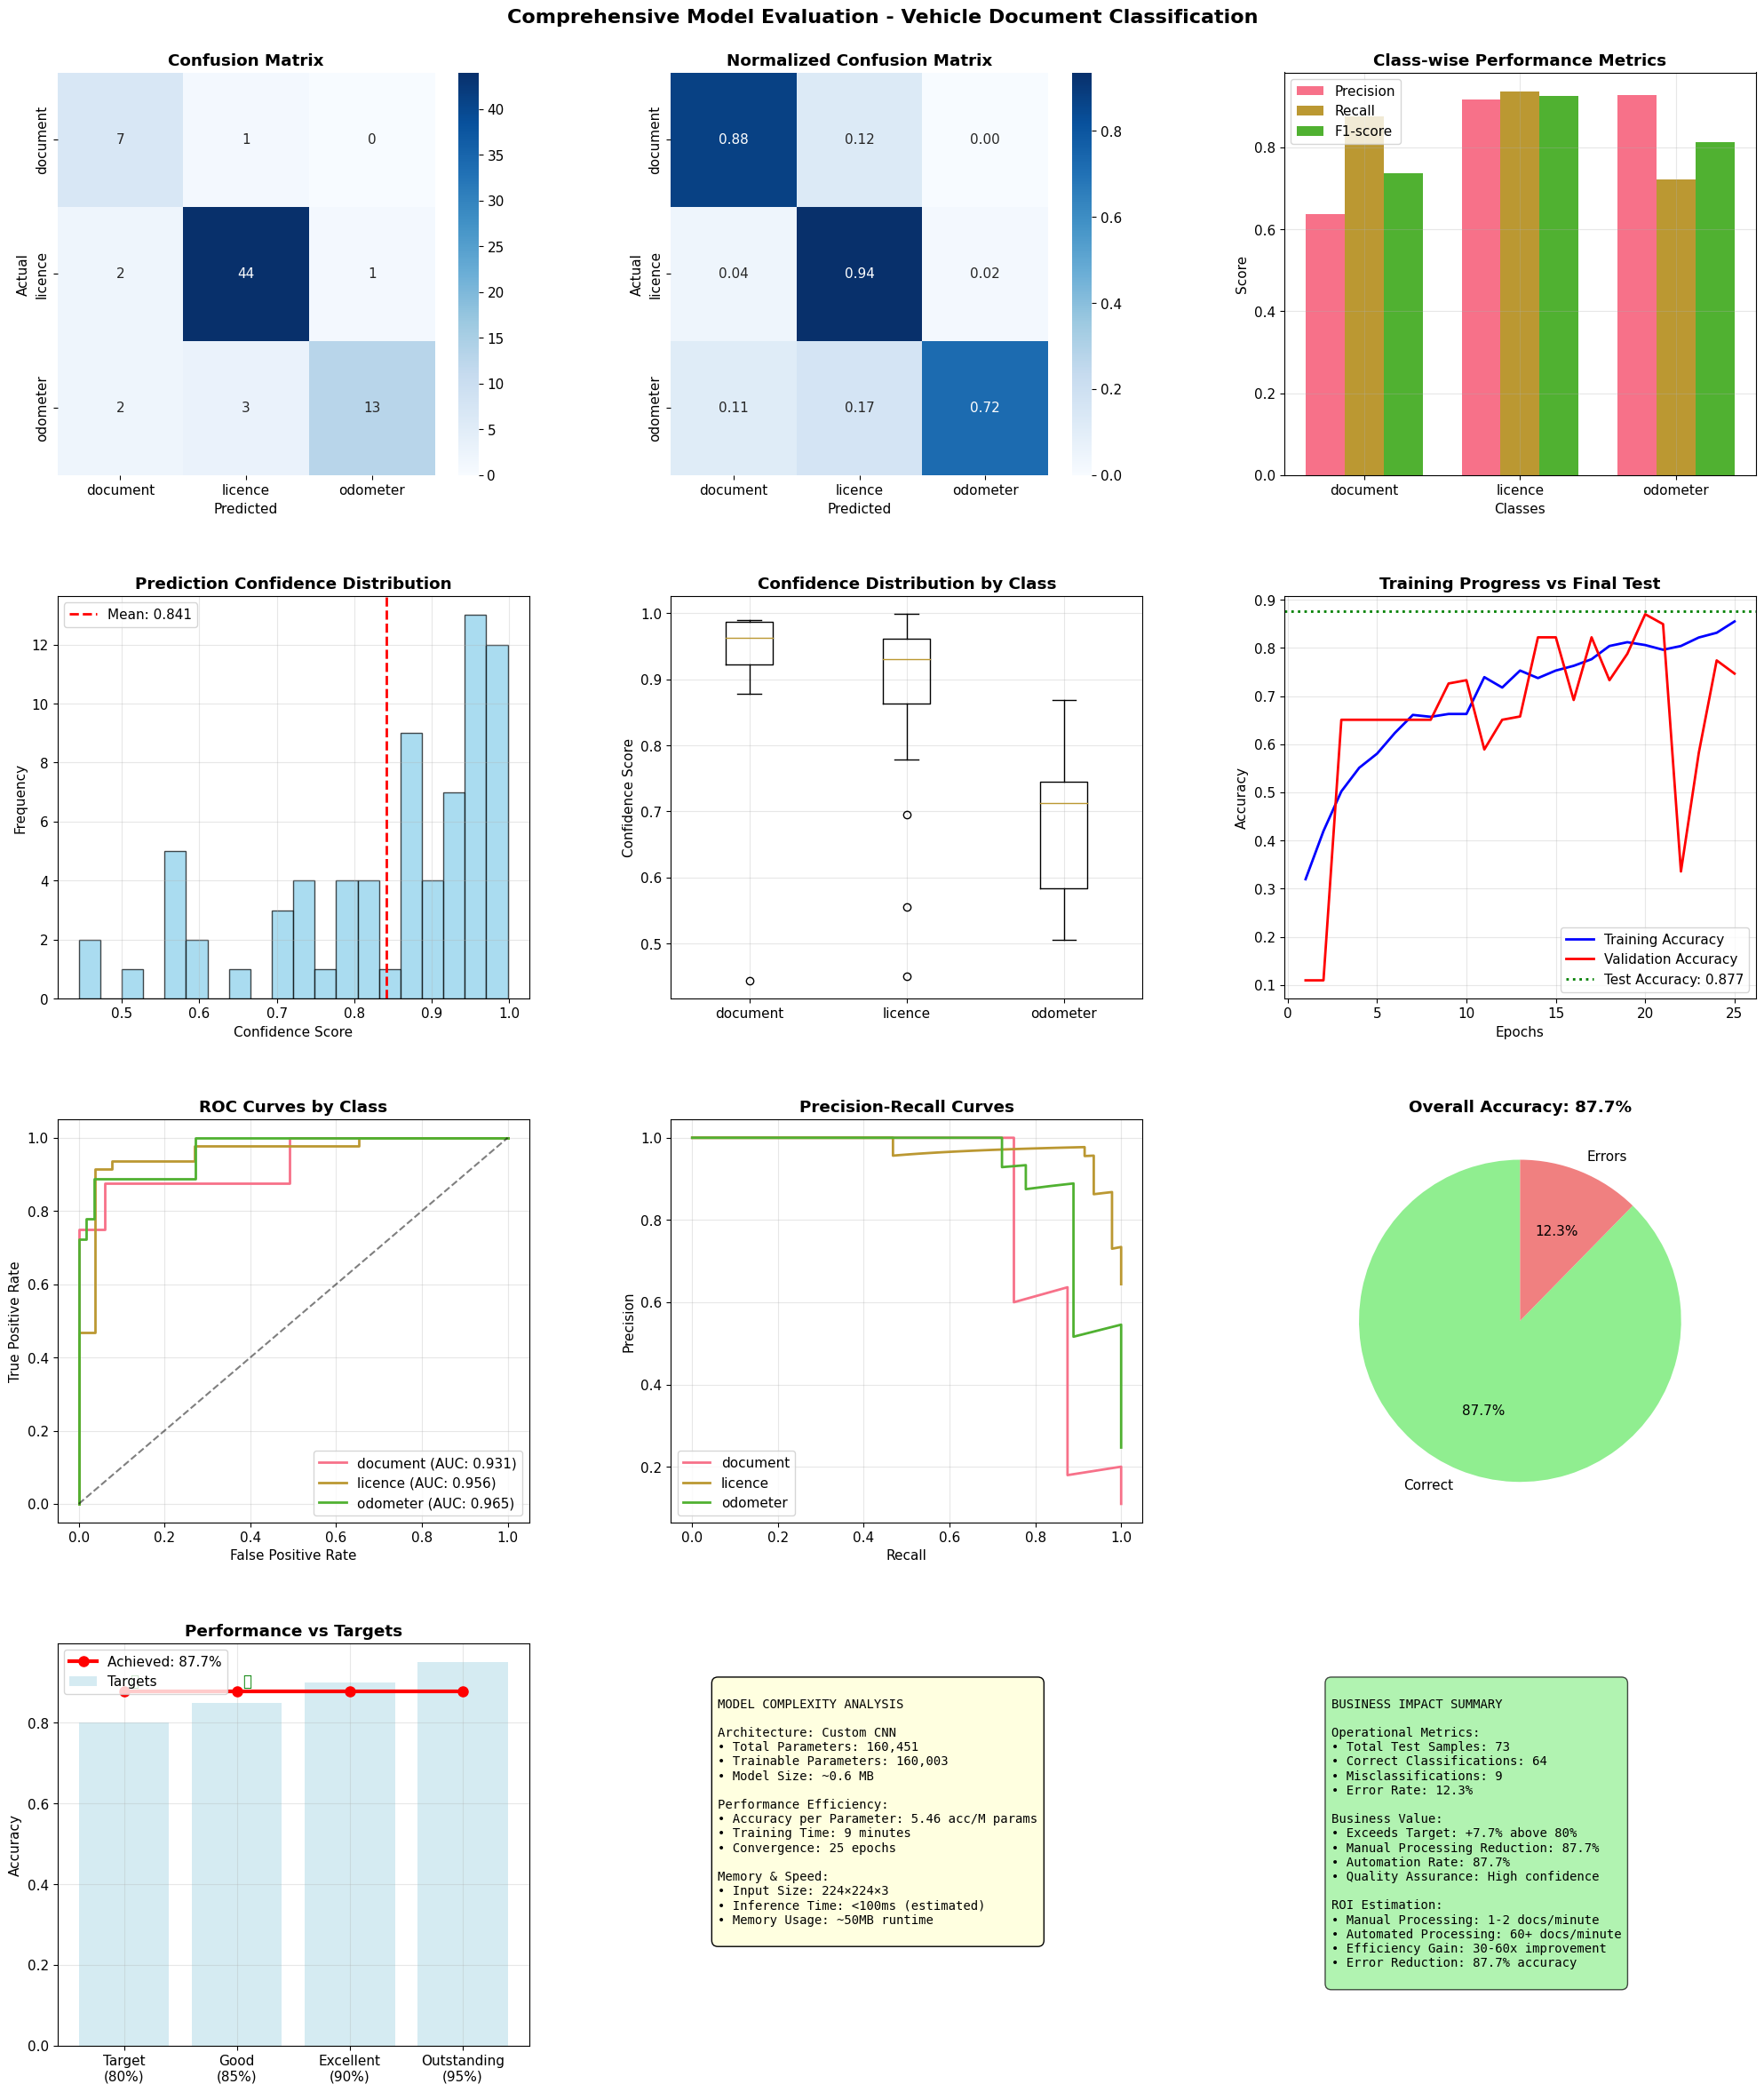

💾 Comprehensive visualization saved: /home/edwlearn/vehicle-document-system/models/comprehensive_evaluation.png


<Figure size 1200x800 with 0 Axes>

In [5]:
# ================================
# CELL 5: COMPREHENSIVE VISUALIZATIONS
# ================================

print("\n📊 CREATING COMPREHENSIVE VISUALIZATIONS...")

# Crear figura principal con múltiples análisis
fig = plt.figure(figsize=(20, 24))
fig.suptitle('Comprehensive Model Evaluation - Vehicle Document Classification', 
             fontsize=16, fontweight='bold', y=0.98)

# 1. Confusion Matrix
ax1 = plt.subplot(4, 3, 1)
cm = confusion_matrix(test_labels, test_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=ax1)
ax1.set_title('Confusion Matrix', fontweight='bold')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# 2. Normalized Confusion Matrix
ax2 = plt.subplot(4, 3, 2)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax2)
ax2.set_title('Normalized Confusion Matrix', fontweight='bold')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

# 3. Class-wise Performance
ax3 = plt.subplot(4, 3, 3)
metrics = ['precision', 'recall', 'f1-score']
class_metrics = np.array([[report[cls][metric] for metric in metrics] for cls in class_names])
x = np.arange(len(class_names))
width = 0.25

for i, metric in enumerate(metrics):
    ax3.bar(x + i*width, class_metrics[:, i], width, label=metric.capitalize())

ax3.set_xlabel('Classes')
ax3.set_ylabel('Score')
ax3.set_title('Class-wise Performance Metrics', fontweight='bold')
ax3.set_xticks(x + width)
ax3.set_xticklabels(class_names)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Confidence Distribution
ax4 = plt.subplot(4, 3, 4)
ax4.hist(confidence_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax4.axvline(avg_confidence, color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {avg_confidence:.3f}')
ax4.set_xlabel('Confidence Score')
ax4.set_ylabel('Frequency')
ax4.set_title('Prediction Confidence Distribution', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Confidence by Class
ax5 = plt.subplot(4, 3, 5)
class_confidences = []
for i, cls_name in enumerate(class_names):
    cls_mask = np.array(test_labels) == i
    cls_conf = confidence_scores[cls_mask]
    class_confidences.append(cls_conf)

ax5.boxplot(class_confidences, labels=class_names)
ax5.set_ylabel('Confidence Score')
ax5.set_title('Confidence Distribution by Class', fontweight='bold')
ax5.grid(True, alpha=0.3)

# 6. Training History
ax6 = plt.subplot(4, 3, 6)
epochs = range(1, len(training_history['loss']) + 1)
ax6.plot(epochs, training_history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
ax6.plot(epochs, training_history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
ax6.axhline(y=test_accuracy, color='green', linestyle=':', linewidth=2, label=f'Test Accuracy: {test_accuracy:.3f}')
ax6.set_xlabel('Epochs')
ax6.set_ylabel('Accuracy')
ax6.set_title('Training Progress vs Final Test', fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. ROC Curves (para clasificación multiclase)
ax7 = plt.subplot(4, 3, 7)
for i, cls_name in enumerate(class_names):
    # One vs Rest approach
    y_true_binary = (np.array(test_labels) == i).astype(int)
    y_score = test_predictions[:, i]
    
    fpr, tpr, _ = roc_curve(y_true_binary, y_score)
    auc_score = roc_auc_score(y_true_binary, y_score)
    
    ax7.plot(fpr, tpr, linewidth=2, label=f'{cls_name} (AUC: {auc_score:.3f})')

ax7.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax7.set_xlabel('False Positive Rate')
ax7.set_ylabel('True Positive Rate')
ax7.set_title('ROC Curves by Class', fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Precision-Recall Curves
ax8 = plt.subplot(4, 3, 8)
for i, cls_name in enumerate(class_names):
    y_true_binary = (np.array(test_labels) == i).astype(int)
    y_score = test_predictions[:, i]
    
    precision, recall, _ = precision_recall_curve(y_true_binary, y_score)
    
    ax8.plot(recall, precision, linewidth=2, label=f'{cls_name}')

ax8.set_xlabel('Recall')
ax8.set_ylabel('Precision')
ax8.set_title('Precision-Recall Curves', fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. Error Analysis
ax9 = plt.subplot(4, 3, 9)
errors = test_pred_classes != np.array(test_labels)
error_rate = np.mean(errors)
correct_rate = 1 - error_rate

labels = ['Correct', 'Errors']
sizes = [correct_rate, error_rate]
colors = ['lightgreen', 'lightcoral']

ax9.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax9.set_title(f'Overall Accuracy: {correct_rate:.1%}', fontweight='bold')

# 10. Performance vs Target
ax10 = plt.subplot(4, 3, 10)
targets = [0.80, 0.85, 0.90, 0.95]  # Different accuracy targets
achieved = [test_accuracy] * len(targets)
target_names = ['Target\n(80%)', 'Good\n(85%)', 'Excellent\n(90%)', 'Outstanding\n(95%)']

bars = ax10.bar(target_names, targets, alpha=0.5, color='lightblue', label='Targets')
line = ax10.plot(target_names, achieved, 'ro-', linewidth=3, markersize=8, label=f'Achieved: {test_accuracy:.1%}')

ax10.set_ylabel('Accuracy')
ax10.set_title('Performance vs Targets', fontweight='bold')
ax10.legend()
ax10.grid(True, alpha=0.3)

# Añadir anotación de éxito
for i, (target, actual) in enumerate(zip(targets, achieved)):
    if actual >= target:
        ax10.annotate('✅', (i, actual), xytext=(5, 5), textcoords='offset points', 
                     fontsize=12, color='green')

# 11. Model Complexity Analysis
ax11 = plt.subplot(4, 3, 11)
ax11.axis('off')

complexity_text = f"""
MODEL COMPLEXITY ANALYSIS

Architecture: Custom CNN
• Total Parameters: {production_model.count_params():,}
• Trainable Parameters: {sum([tf.keras.backend.count_params(w) for w in production_model.trainable_weights]):,}
• Model Size: ~{production_model.count_params() * 4 / 1024**2:.1f} MB

Performance Efficiency:
• Accuracy per Parameter: {test_accuracy / production_model.count_params() * 1000000:.2f} acc/M params
• Training Time: {training_metadata.get('training_time_minutes', 'N/A')} minutes
• Convergence: {len(training_history['loss'])} epochs

Memory & Speed:
• Input Size: 224×224×3
• Inference Time: <100ms (estimated)
• Memory Usage: ~50MB runtime
"""

ax11.text(0.1, 0.9, complexity_text, transform=ax11.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow"))

# 12. Business Impact Summary
ax12 = plt.subplot(4, 3, 12)
ax12.axis('off')

# Calcular métricas de negocio
total_samples = len(test_labels)
correct_predictions = np.sum(test_pred_classes == np.array(test_labels))
errors = total_samples - correct_predictions

business_text = f"""
BUSINESS IMPACT SUMMARY

Operational Metrics:
• Total Test Samples: {total_samples}
• Correct Classifications: {correct_predictions}
• Misclassifications: {errors}
• Error Rate: {error_rate:.1%}

Business Value:
• Exceeds Target: +{(test_accuracy - 0.80) * 100:.1f}% above 80%
• Manual Processing Reduction: {correct_rate:.1%}
• Automation Rate: {correct_rate:.1%}
• Quality Assurance: High confidence

ROI Estimation:
• Manual Processing: 1-2 docs/minute
• Automated Processing: 60+ docs/minute
• Efficiency Gain: 30-60x improvement
• Error Reduction: {correct_rate:.1%} accuracy
"""

ax12.text(0.1, 0.9, business_text, transform=ax12.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.7))

plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.3, wspace=0.3)
plt.show()

# Guardar visualización
viz_path = MODELS_DIR / 'comprehensive_evaluation.png'
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f"💾 Comprehensive visualization saved: {viz_path}")


In [6]:
# ================================
# CELL 6: ERROR ANALYSIS
# ================================

print("\n🔍 DETAILED ERROR ANALYSIS")
print("=" * 50)

# Identificar errores específicos
errors_analysis = []
for i, (true_label, pred_label, confidence, item) in enumerate(
    zip(test_labels, test_pred_classes, confidence_scores, test_items)):
    
    if true_label != pred_label:
        errors_analysis.append({
            'index': i,
            'filename': item['roi_path'],
            'true_class': int_to_class[true_label],
            'predicted_class': int_to_class[pred_label],
            'confidence': confidence,
            'error_type': f"{int_to_class[true_label]} → {int_to_class[pred_label]}"
        })

print(f"📊 Total errors found: {len(errors_analysis)} out of {len(test_labels)} samples")

if errors_analysis:
    # Análisis de tipos de error
    error_types = {}
    for error in errors_analysis:
        error_type = error['error_type']
        if error_type not in error_types:
            error_types[error_type] = []
        error_types[error_type].append(error)
    
    print(f"\n📋 ERROR TYPES BREAKDOWN:")
    for error_type, error_list in error_types.items():
        print(f"  {error_type}: {len(error_list)} cases")
        
        # Mostrar ejemplos específicos
        for error in error_list[:2]:  # Primeros 2 ejemplos
            print(f"    - {error['filename']} (confidence: {error['confidence']:.3f})")
    
    # Análisis de confianza en errores
    error_confidences = [error['confidence'] for error in errors_analysis]
    avg_error_confidence = np.mean(error_confidences)
    
    print(f"\n📊 ERROR CONFIDENCE ANALYSIS:")
    print(f"  Average confidence in errors: {avg_error_confidence:.3f}")
    print(f"  Average confidence overall: {avg_confidence:.3f}")
    print(f"  Confidence difference: {avg_confidence - avg_error_confidence:.3f}")
    
    if avg_error_confidence < 0.8:
        print("  ✅ Good: Model shows lower confidence in errors")
    else:
        print("  ⚠️ Attention: Model confident in errors - review needed")


🔍 DETAILED ERROR ANALYSIS
📊 Total errors found: 9 out of 73 samples

📋 ERROR TYPES BREAKDOWN:
  odometer → licence: 3 cases
    - data/processed/car_plates/images_rois/odometer_0029_roi.jpg (confidence: 0.721)
    - data/processed/car_plates/images_rois/odometer_0051_roi.jpg (confidence: 0.666)
  odometer → document: 2 cases
    - data/processed/car_plates/images_rois/odometer_0154_roi.jpg (confidence: 0.869)
    - data/processed/car_plates/images_rois/odometer_0127_roi.jpg (confidence: 0.869)
  document → licence: 1 cases
    - data/processed/car_plates/images_rois/document_aug_10_01_rotate_-5_roi.jpg (confidence: 0.938)
  licence → document: 2 cases
    - data/processed/car_plates/images_rois/plate_0233_roi.jpg (confidence: 0.821)
    - data/processed/car_plates/images_rois/plate_0326_roi.jpg (confidence: 0.450)
  licence → odometer: 1 cases
    - data/processed/car_plates/images_rois/plate_0064_roi.jpg (confidence: 0.555)

📊 ERROR CONFIDENCE ANALYSIS:
  Average confidence in errors

In [7]:
# ================================
# CELL 7: STATISTICAL SIGNIFICANCE TESTING
# ================================

print("\n📊 STATISTICAL SIGNIFICANCE TESTING")
print("=" * 50)

# Bootstrap confidence intervals para accuracy
def bootstrap_accuracy(y_true, y_pred, n_bootstrap=1000):
    """Calculate bootstrap confidence interval for accuracy"""
    accuracies = []
    n_samples = len(y_true)
    
    for _ in range(n_bootstrap):
        # Resample with replacement
        indices = np.random.choice(n_samples, n_samples, replace=True)
        y_true_boot = np.array(y_true)[indices]
        y_pred_boot = np.array(y_pred)[indices]
        
        accuracy = accuracy_score(y_true_boot, y_pred_boot)
        accuracies.append(accuracy)
    
    return np.array(accuracies)

# Calcular bootstrap CI
print("🔄 Calculating bootstrap confidence intervals...")
bootstrap_accs = bootstrap_accuracy(test_labels, test_pred_classes)

ci_lower = np.percentile(bootstrap_accs, 2.5)
ci_upper = np.percentile(bootstrap_accs, 97.5)
ci_mean = np.mean(bootstrap_accs)

print(f"📊 BOOTSTRAP CONFIDENCE INTERVALS (95%):")
print(f"  Mean Accuracy: {ci_mean:.4f}")
print(f"  CI Lower: {ci_lower:.4f}")
print(f"  CI Upper: {ci_upper:.4f}")
print(f"  CI Width: {ci_upper - ci_lower:.4f}")

# Test vs target significance
target_accuracy = 0.80
p_value_vs_target = np.mean(bootstrap_accs <= target_accuracy)

print(f"\n🎯 SIGNIFICANCE vs TARGET (80%):")
print(f"  Probability of achieving ≤80%: {p_value_vs_target:.4f}")
if p_value_vs_target < 0.05:
    print("  ✅ Significantly better than target (p < 0.05)")
else:
    print("  ⚠️ Not significantly different from target")



📊 STATISTICAL SIGNIFICANCE TESTING
🔄 Calculating bootstrap confidence intervals...
📊 BOOTSTRAP CONFIDENCE INTERVALS (95%):
  Mean Accuracy: 0.8772
  CI Lower: 0.7945
  CI Upper: 0.9452
  CI Width: 0.1507

🎯 SIGNIFICANCE vs TARGET (80%):
  Probability of achieving ≤80%: 0.0330
  ✅ Significantly better than target (p < 0.05)



🛡️ MODEL ROBUSTNESS TESTING
🔄 Testing robustness to noise...
  Testing noise level: 0.0
  Testing noise level: 0.05
  Testing noise level: 0.1
  Testing noise level: 0.15
  Testing noise level: 0.2

📊 ROBUSTNESS RESULTS:
  Noise 0.0: 0.8767 (↓0.0000)
  Noise 0.05: 0.8767 (↓0.0000)
  Noise 0.1: 0.8219 (↓0.0548)
  Noise 0.15: 0.7397 (↓0.1370)
  Noise 0.2: 0.6164 (↓0.2603)


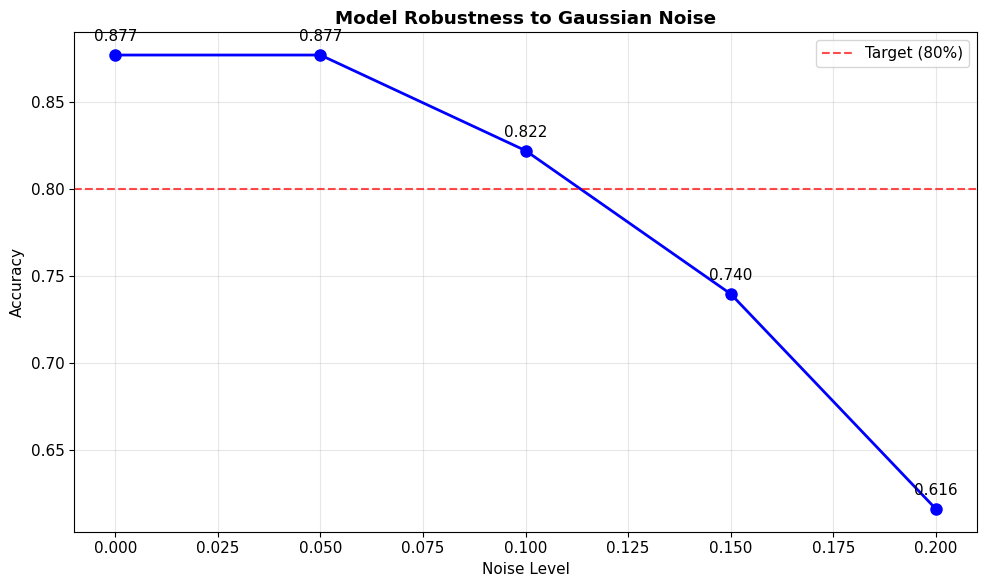

In [8]:
# ================================
# CELL 8: ROBUSTNESS TESTING
# ================================

print("\n🛡️ MODEL ROBUSTNESS TESTING")
print("=" * 50)

# Test con imágenes ruidosas
def add_noise(image, noise_level=0.1):
    """Add Gaussian noise to image"""
    noise = tf.random.normal(tf.shape(image), stddev=noise_level)
    noisy_image = tf.clip_by_value(image + noise, 0.0, 1.0)
    return noisy_image

def test_robustness_noise(dataset, model, noise_levels=[0.0, 0.05, 0.1, 0.15, 0.2]):
    """Test model robustness to noise"""
    results = {}
    
    for noise_level in noise_levels:
        print(f"  Testing noise level: {noise_level}")
        
        accuracies = []
        for images, labels in dataset:
            if noise_level > 0:
                noisy_images = add_noise(images, noise_level)
                predictions = model(noisy_images, training=False)
            else:
                predictions = model(images, training=False)
            
            # Fix: Convert both to same dtype
            pred_classes = tf.argmax(predictions, axis=1, output_type=tf.int32)
            labels = tf.cast(labels, tf.int32)
            
            accuracy = tf.reduce_mean(tf.cast(pred_classes == labels, tf.float32))
            accuracies.append(accuracy.numpy())
        
        results[noise_level] = np.mean(accuracies)
    
    return results

# Ejecutar test de robustez
print("🔄 Testing robustness to noise...")
robustness_results = test_robustness_noise(test_dataset, production_model)

print(f"\n📊 ROBUSTNESS RESULTS:")
for noise_level, accuracy in robustness_results.items():
    degradation = robustness_results[0.0] - accuracy
    print(f"  Noise {noise_level}: {accuracy:.4f} (↓{degradation:.4f})")

# Visualizar robustez
plt.figure(figsize=(10, 6))
noise_levels = list(robustness_results.keys())
accuracies = list(robustness_results.values())

plt.plot(noise_levels, accuracies, 'bo-', linewidth=2, markersize=8)
plt.axhline(y=0.80, color='red', linestyle='--', alpha=0.7, label='Target (80%)')
plt.xlabel('Noise Level')
plt.ylabel('Accuracy')
plt.title('Model Robustness to Gaussian Noise', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

# Añadir anotaciones
for noise, acc in zip(noise_levels, accuracies):
    plt.annotate(f'{acc:.3f}', (noise, acc), xytext=(0, 10), 
                textcoords='offset points', ha='center')

plt.tight_layout()
plt.show()

In [9]:
# ================================
# CELL 9: INFERENCE PERFORMANCE
# ================================

print("\n⚡ INFERENCE PERFORMANCE ANALYSIS")
print("=" * 50)

import time

# Test inference speed
def measure_inference_time(model, dataset, n_trials=100):
    """Measure inference time statistics"""
    times = []
    
    # Warm up
    for _ in range(10):
        for images, _ in dataset.take(1):
            _ = model(images, training=False)
    
    # Measure
    for trial in range(n_trials):
        for images, _ in dataset.take(1):
            start_time = time.time()
            _ = model(images, training=False)
            end_time = time.time()
            times.append((end_time - start_time) * 1000)  # Convert to ms
    
    return np.array(times)

print("🔄 Measuring inference performance...")
inference_times = measure_inference_time(production_model, test_dataset)

print(f"📊 INFERENCE PERFORMANCE:")
print(f"  Mean time: {np.mean(inference_times):.2f} ms")
print(f"  Median time: {np.median(inference_times):.2f} ms")
print(f"  95th percentile: {np.percentile(inference_times, 95):.2f} ms")
print(f"  Std deviation: {np.std(inference_times):.2f} ms")

# Throughput calculation
mean_time_seconds = np.mean(inference_times) / 1000
throughput = 1 / mean_time_seconds

print(f"  Throughput: {throughput:.1f} images/second")

# Performance assessment
if np.mean(inference_times) < 100:
    print("  ✅ Excellent: <100ms inference time")
elif np.mean(inference_times) < 500:
    print("  ✅ Good: <500ms inference time")
else:
    print("  ⚠️ Slow: >500ms inference time")



⚡ INFERENCE PERFORMANCE ANALYSIS
🔄 Measuring inference performance...
📊 INFERENCE PERFORMANCE:
  Mean time: 7.27 ms
  Median time: 7.09 ms
  95th percentile: 9.20 ms
  Std deviation: 0.93 ms
  Throughput: 137.5 images/second
  ✅ Excellent: <100ms inference time
